In [1]:
import json
import requests
import os
import urllib
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Graphs
from rdkit.Chem import rdmolops
from rdkit.Chem import Draw
# with CoordGen
from rdkit.Chem import rdCoordGen
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

IPythonConsole.drawOptions.addAtomIndices = True #индексируем атомы

## Скачиваем данные

In [2]:
url = 'https://bitbucket.org/sib-pig/rban/raw/0190ed2f49d6e52d8454f7e99add24a715ece4aa/src/main/resources/molecules/monomer/nrproMonomers.json'
response = requests.get(url)

monomers = json.loads(response.text)
#response.raise_for_status()  # raises exception when not a 2xx response
#if response.status_code != 204:
 #   print(response.text)
  #  monomers = json.loads(response)

In [3]:
#Можно раскомментировать, чтобы убедиться что это json
#monomers

### Создаем словарь monomer:smiles

In [4]:
monomers_dict = {}
for mon in monomers:
    monomers_dict[mon['monomer']] = mon['smiles'] 

In [5]:
#Вывод словаря
#print(monomers_dict)

In [6]:
monomers_dict['Phe'] #проверка,что в словаре есть нужные аминокислоты

'NC(Cc1ccccc1)C(=O)O'

In [7]:
monomers_dict['C12:1(5)-OH(3)'] 

'CCCCCCC=CCC(O)CC(O)=O'

### Выделим необходимые для построения регулярные выражения

In [8]:
part_O_C_OH = Chem.MolFromSmiles('C(=O)O')#O=C-OH 

In [9]:
without_radical = Chem.MolFromSmiles('NCC(=O)O')#NH2_C_C_O_OH

In [10]:
amino_group = Chem.MolFromSmiles('NC')#NH2_C

In [11]:
without_OH = Chem.MolFromSmiles('NCC(=O)')#NH2-C-C=O

In [12]:
part_OH = Chem.MolFromSmiles('CO')#NH2-C-C=O

In [13]:
part_O = Chem.MolFromSmiles('C(=O)')#C=O

## Создаем граф

In [14]:
def make_list_of_moleculas(list_of_acids):
    """
    Makes list of moleculas from string of moleculas
    
    Returns: list of moleculas
    """
    list_of_mols = []
    for acid in list_of_acids:
        list_of_mols.append(Chem.MolFromSmiles(monomers_dict[acid]))
    return list_of_mols

In [15]:
class Graph:
    """
    Graph class represents a graph, which we got from input

    - list_of_monomers: list of vertex in graph
    - list_of_edges: list of edges in graph
    - processed: list of flags, that showa wheather we have already visited these vertexes or not

    You might want to add other fields/methods for Peptide
    """
    def __init__(self):
        
        self.list_of_monomers = []
        self.list_of_edges = []
        #self.types = {}
        self.processed = []
    

    def read_from_string(self, graph_string): 
        '''
        Converting a string like (Phe,Ser,Cl2-Pro,Abu,Ser;0,1;1,2;2,3;3,4;4,0) to a graph
        '''
        list = graph_string.split(';')
        self.list_of_monomers = make_list_of_moleculas(list[0].split(','))
        for i in range(len(self.list_of_monomers)):
            self.processed.append(False)
        for i in range(1, len(list)):
            pair = (int(list[i].split(',')[0]), int(list[i].split(',')[1]))
            self.list_of_edges.append(pair)
     
    def was_processed(self, index):
        '''
        Check if the monomer was add to peptide.
        
        Returns: True, if the mnomer was processed
        '''
        return self.processed[index]

    def type_of_edge(self, edge):
        '''
        Check a type of edge
        
        Returns: type of edge: amino, etc
        '''
        pass 
    
    def get_successors(self, index):
        '''
        Get a list of successors of the monomer.
        
        Returns: list of successors
        '''
        successors = []
        for edges in self.list_of_edges:
            if edges[0] == index:
                successors.append(edges[1])    
        return successors
    def get_parents(self, index):
        parents = []
        for edges in self.list_of_edges:
            if edges[1] == index:
                parents.append(edges[0])    
        return parents

    def type_of_graph(self):
        '''
        Check a type of graph:  simple sequence, simple cycle or complex graph.
        
        Returns: string type
        '''
        cnt = 0
        out_deg=[]
        for i in range(len(self.list_of_monomers)):
            out_deg.append(len(self.get_successors(i)))
            if out_deg[i] >=2:
                return "Complex"
            if out_deg[i]==1:
                cnt+=1
        if cnt == len(self.list_of_monomers):
            return "Cycle"
        elif cnt == len(self.list_of_monomers)-1:
            return "SimpleSeq"
        else:
            return "Graph is not connected"
        
    def find_starting_monomer(self):
        '''
        Find an index of monomer from which better to start building peptide. Find a vertex of amino group with min degree 
        
        Returns: An index of monomer
        '''
        min_degree=5 #кажется больше не нужно с химической точки зрения
        for i in range(len(self.list_of_monomers)):
            if min_degree > len(self.list_of_monomers[i].GetSubstructMatches(amino_group)):
                min_degree = len(self.list_of_monomers[i].GetSubstructMatches(amino_group))
                index = i
        return index
            

In [16]:
peptide_graph = Graph()

In [17]:
peptide_graph.read_from_string("Cl2-Pro,Abu,Ser,Phe,Ser;0,1;1,2;2,3;3,4;4,0") #Граф для примера
#peptide_graph.read_from_string("Phe,Ser,Cl2-Pro,Abu,Ser;0,1;1,2;2,3;3,4;4,0")

## Построение пептида

In [18]:
monomers = peptide_graph.list_of_monomers

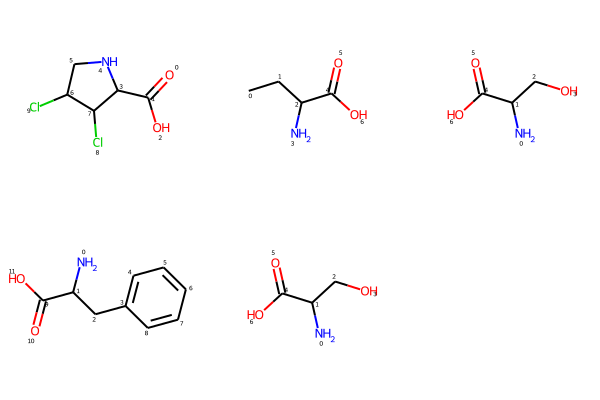

In [19]:
MolsToGridImage(monomers)

In [20]:
#класс будет усложнятся по мере усложнений
class Peptide: 
    """
    Peptide class represents a peptide, which we build

    - mol: molecula, which we already built
    - successors: list of successors of subgraph, that represent the molecula 

    You might want to add other fields/methods for Peptide
    """
    def __init__(self, mol,successors):
        self.mol = mol
        self.successors=successors

In [21]:
def remove_OH(mol):
    """
    Removes -OH from carboxyl group of molecula
    
    Returns: Molecula without -OH
    """
    mw1 = Chem.RWMol(mol)
    mw1.RemoveAtom(mol.GetSubstructMatches(without_radical)[0][4])
    return mw1

In [22]:
def find_amino_index(amino_linkages):
    """
    Finds amino group with minimum amount of linkages
    
    Returns: amino group index
    """
    dict_freq = {}
    for link in amino_linkages:
        if  link[0] in dict_freq:
            dict_freq[link[0]] +=1
        else:
            dict_freq[link[0]] =1
    min_freq_link = ("", 4)
    for link in dict_freq:
        if dict_freq[link] < min_freq_link[1]:
            min_freq_link = (link,dict_freq[link]) 
    return min_freq_link[0]

In [23]:
def peptide_linkage(mol_without_OH, next_mol):
    """
    Makes peptide linkage between peptide and new monomer
    
    Returns: new smiles, peptide
    """
    combo = Chem.CombineMols(mol_without_OH, next_mol)
    edcombo = Chem.EditableMol(combo)
    combo.GetSubstructMatches(without_OH)
    edcombo.AddBond(mol_without_OH.GetNumAtoms()-2, combo.GetSubstructMatches(amino_group)[-1][0],
                    order=Chem.rdchem.BondType.SINGLE)
    back = edcombo.GetMol()
    back2 = Chem.MolToSmiles(back)
    peptide = Chem.MolFromSmiles(back2)
    return back2, peptide

In [24]:
def monomers_to_peptide(graph):
    """
    Link monomers in sequence or cycle
    
    Returns: smiles, peptide
    """
    start_index = peptide_graph.find_starting_monomer()
    peptide = Peptide(graph.list_of_monomers[start_index], graph.get_successors(start_index))
    graph.processed[start_index]=True
    while len(peptide.successors) != 0 and graph.was_processed(peptide.successors[0]) == False:
        graph.processed[peptide.successors[0]]=True #помечаем присоединяемый мономер как посещенный
        #если будет больше соседей, придется усложнять функцию
        smile, peptide.mol = peptide_linkage(remove_OH(peptide.mol), graph.list_of_monomers[peptide.successors[0]])
        peptide.successors = graph.get_successors(peptide.successors[0])
        
    if graph.was_processed(peptide.successors[0]):
        peptide.mol = remove_OH(peptide.mol)
        peptw = Chem.RWMol(peptide.mol)
        peptw.AddBond(peptide.mol.GetNumAtoms()-2, find_amino_index(peptide.mol.GetSubstructMatches(amino_group)),
                    order=Chem.rdchem.BondType.SINGLE)
        back = peptw.GetMol()
        smile = Chem.MolToSmiles(back)
        peptide.mol = Chem.MolFromSmiles(smile)
    return smile, peptide.mol

In [25]:
smile, peptide = monomers_to_peptide(peptide_graph)

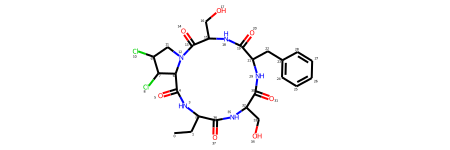

In [26]:
peptide

In [27]:
smile

'CCC1NC(=O)C2C(Cl)C(Cl)CN2C(=O)C(CO)NC(=O)C(Cc2ccccc2)NC(=O)C(CO)NC1=O'